# Feature Reduction

In this notebook we'll take a look at the features in our training set and try to determine if there are any features we can remove.

In [1]:
# Import packages
import sys
sys.path.append('../../')

from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.cluster import hierarchy
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

import collegebasketball as cbb
cbb.__version__

'2022'

### Read in the Training Data

To start with, we'll read in the training data and take a quick look at the features. We can see below that there are 263 columns in the data set, and though six of them are not feature, we'll try and determine if all of them are needed in our model. 

First, we'll read in the full training data set and we'll remove some features that I know are almost identical to other columns in the data. For example, the `AdjOE` feature from the T-Rank data is essentially the same as the `AdjO` feature from the Kenpom data. Generally, we'll keep the Kenpom version of any features that are common across other data sources.

Next, we'll further split the data into a training and test set so we can verify that the features we removed don't have too large of an impact on the predictive power of our training data.

In [2]:
# Paths to datasets
path_dir = '../../Data/Training/large_training.csv'

# Read in data
df = pd.read_csv(path_dir)
df.columns

Index(['Favored', 'Underdog', 'Year', 'Tournament', 'Win_Loss_Fav', 'Win_Loss',
       'Win_Loss_Diff', 'Rank_Fav', 'Rank', 'Rank_Diff',
       ...
       'TOV_Diff', 'TOV_opp_Fav', 'TOV_opp', 'TOV_opp_Diff', 'PF_Fav', 'PF',
       'PF_Diff', 'PF_opp_Fav', 'PF_opp', 'PF_opp_Diff'],
      dtype='object', length=263)

In [3]:
# We want to drop columns that are almost exactly the same before this analysis
repeat_cols = ['Barthag', 'AdjOE', 'AdjDE', 'Adj T.', 'WAB', 'MP', 'FG%', 'FG%_opp', '3P%', '3P%_opp']

# For this analysis we will not include non-feature, difference or rank columns
cols_to_drop = (
    ['Favored', 'Underdog', 'Year', 'Tournament', 'Seed_Fav', 'Seed'] + 
    [col for col in df.columns if '_Diff' in col or 'Rank' in col or 'Rk' in col] +
    repeat_cols + [col + '_Fav' for col in repeat_cols]
)

tourney = cbb.filter_tournament(df).drop(cols_to_drop, axis=1)
regular = cbb.filter_tournament(df, drop=True).drop(cols_to_drop, axis=1)

print(f'We have {len(regular)} regular season games and {len(tourney)} NCAA Tournament games.')

We have 14050 regular season games and 600 NCAA Tournament games.


In [4]:
# Split into train and test sets with an equal proportion of actual tournament games in each
regular_train, regular_test = train_test_split(regular, random_state=77)
tourney_train, tourney_test = train_test_split(tourney, random_state=77)

train = pd.concat([regular_train, tourney_train])
test = pd.concat([regular_test, tourney_test])

print(f'There are {len(train)} games in the training set and {len(test)} games in the test set.')

There are 10987 games in the training set and 3663 games in the test set.


In [5]:
clf = RandomForestClassifier(n_estimators=100, random_state=77)
clf.fit(train.drop('Label', axis=1), train['Label'])
print("Accuracy on test data: {:.2f}".format(clf.score(test.drop('Label', axis=1), test['Label'])))

Accuracy on test data: 0.63


We can see that we get an accuracy of 63% when using all of the features from the training data to train a simple random forest model to predict on the test set. After we remove any additional features, we'll run train another model with the reduced data set and test it again to make sure we don't negatively impact performance.

### Examine Correlated Features

We know that there's some overlap between the features from the different data sources, with some being exact copies and others being highly correlated. We've already removed some obviously similar features already, but next we'll take a closer look at the correlation among the remaining features to try and find more redundancies. We'll take a look at a visualization of the correlation matrix between the features as well as the pairs of features with the highest magnitude of correlation to help determine which features we can remove without losing too much predictive signal. We can also use clustering methods to cluster features into groups to help us understand if groups of features - not just pairs - are all similar.

To help simplify this process, we'll only be looking at the features for team considered the underdog. We'll assume that the correlation between features for the favorite follow a similar pattern - that is, if `EFG%` (effective field goal percentage of the underdog) is highly correlated with `2P%` (2 pointer shooting percentage for the underdog), then we will assume the same correlation applies to those two statistics for the favored team.

In [6]:
# Split features in to features for favorite team and those for the underdog
cols_fav = [col for col in train.columns if '_Fav' in col]
X_fav = train[cols_fav]
X_under = train.drop(cols_fav + ['Label'], axis=1)
y = train['Label']

print(len(X_fav.columns), len(X_under.columns))

50 50


<AxesSubplot:>

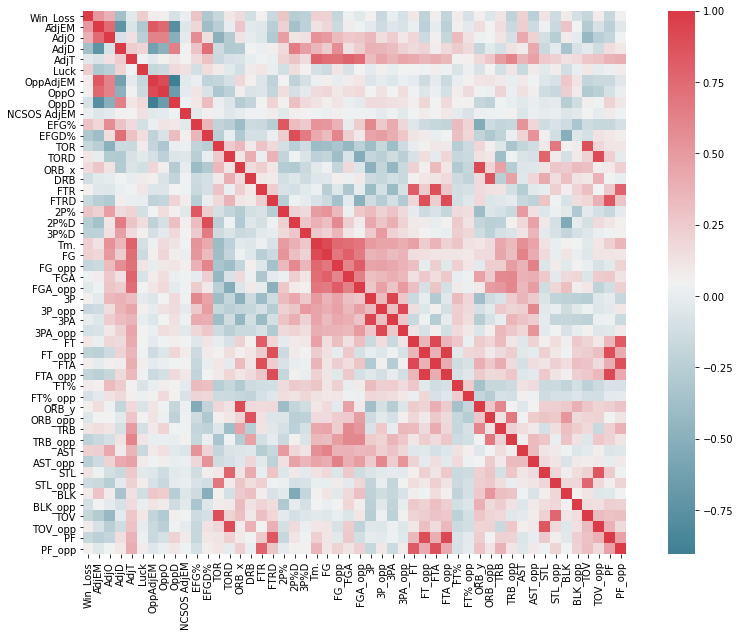

In [7]:
# Since the plots look very similar, we'll just show the plot for the underdog features
f, ax = plt.subplots(figsize=(15, 10))
corr = X_under.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=bool), 
            cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

In [8]:
# Let's take a closer look at feature correlations 
corr_list = X_under.corr().stack()

# Remove correlation of a feature to itself and duplicates
corr_list = corr_list[(corr_list.index.get_level_values(0) != corr_list.index.get_level_values(1)) &
                      (corr_list.index.get_level_values(0) < corr_list.index.get_level_values(1))]

# See top correlation by magnitude
corr_list.apply(abs).sort_values(ascending=False).head(10)

FTA_opp   FT_opp     0.970643
3P        3PA        0.944258
FTA_opp   PF         0.923485
FT        FTA        0.921855
3PA_opp   3P_opp     0.921456
OppAdjEM  OppO       0.916816
ORB_x     ORB_y      0.914303
FG        Tm.        0.911577
TORD      TOV_opp    0.910326
FTA_opp   FTRD       0.908711
dtype: float64

In [9]:
# Cluster features based on correlation magnitude
corr_linkage = hierarchy.ward(X_under.corr().apply(abs))
cluster_ids = hierarchy.fcluster(corr_linkage, 1, criterion='distance')

# Show clusters with more than one feature
cluster_id_to_features = defaultdict(list)
for idx, cluster_id in enumerate(cluster_ids):
    feat = X_under.columns[idx]
    cluster_id_to_features[cluster_id].append(feat)
    
for k in cluster_id_to_features:
    if len(cluster_id_to_features[k]) > 1:
        print(cluster_id_to_features[k])

['AdjEM', 'OppAdjEM', 'OppO', 'OppD']
['AdjT', 'FGA']
['EFG%', '2P%']
['EFGD%', '2P%D']
['ORB_x', 'ORB_y']
['DRB', 'ORB_opp']
['Tm.', 'FG']
['3P', '3PA']
['3P_opp', '3PA_opp']
['FT', 'FTA', 'PF_opp']
['FT_opp', 'FTA_opp', 'PF']
['STL', 'TOV_opp']
['STL_opp', 'TOV']


### Remove Unecessary Features

From the correlation values, we can see that many of the features are highly correlated. By removing features that are highly correlated with at least one feature we are keeping, we can reduce complexity without losing too much additional information that the could have provided. There are a few patterns in the correlation of features above:

1. There are some cases where we have one feature to describe the offense and another feature that describes essentially the same thing from the opposing team's perspective. For example, the `FT` feature and `PF_opp` feature are really both representative of how often the underdog gets fouled. Sure, there are some small differences between the two - you can get fouled without it resulting in free throws - but to help reduce that complexity we'll sacrifice any small bits of information the extra feature could have provided.
2. We often have groups of features from the Sports Reference data set that represent successes, attempts, and success rate. For example, `3P` is the number of made three pointers, `3PA` is the number of threes attempted and `3P%` is the percentage of three pointers made. Since we have the number of attempts and the success rate, the number of successes is redundant and we can remove these features.
3. There are some features from the Sports Reference that are not tempo adjusted that are representative of the same thing as a tempo adjusted version in one of the other two data sets. For exmaple, `TOV` is the number of turnovers, but we have the tempo adjusted version `TOR` from the T-Rank data that is both more accurate and less correlated with the tempo feature.
4. Lastly, there are a couple pairs of features that are very similar to each other that were not removed early. For example, `FGA` and the team's tempo are essentially giving the same information - how many possessions a team gets per game. 

Let's remove the features described above and take another look at some of those correlation metrics from earlier to see how things have changed.

In [10]:
# Remove features where we don't need offensive and defensive numbers 
feats_to_remove = ['FTA_opp', 'PF_opp', 'OppO', 'OppD']

# Remove features that give a success number
feats_to_remove = feats_to_remove + ['FG', 'FG_opp', '3P', '3P_opp', 'FT', 'FT_opp', 'Tm.']

# Remove absolute stats when we have tempo adjusted version
feats_to_remove = feats_to_remove + ['FTA', 'TOV', 'TOV_opp', 'ORB_y', 'ORB_opp', 'TRB', 
                                     'TRB_opp', 'PF', 'STL', 'STL_opp']

# Remove features that are too similar to another
feats_to_remove = feats_to_remove + ['FGA', 'FGA_opp', 'EFG%', 'EFGD%']

X_under_reduced = X_under.drop(feats_to_remove, axis=1)
X_under_reduced.columns

Index(['Win_Loss', 'AdjEM', 'AdjO', 'AdjD', 'AdjT', 'Luck', 'OppAdjEM',
       'NCSOS AdjEM', 'TOR', 'TORD', 'ORB_x', 'DRB', 'FTR', 'FTRD', '2P%',
       '2P%D', '3P%D', '3PA', '3PA_opp', 'FT%', 'FT%_opp', 'AST', 'AST_opp',
       'BLK', 'BLK_opp'],
      dtype='object')

<AxesSubplot:>

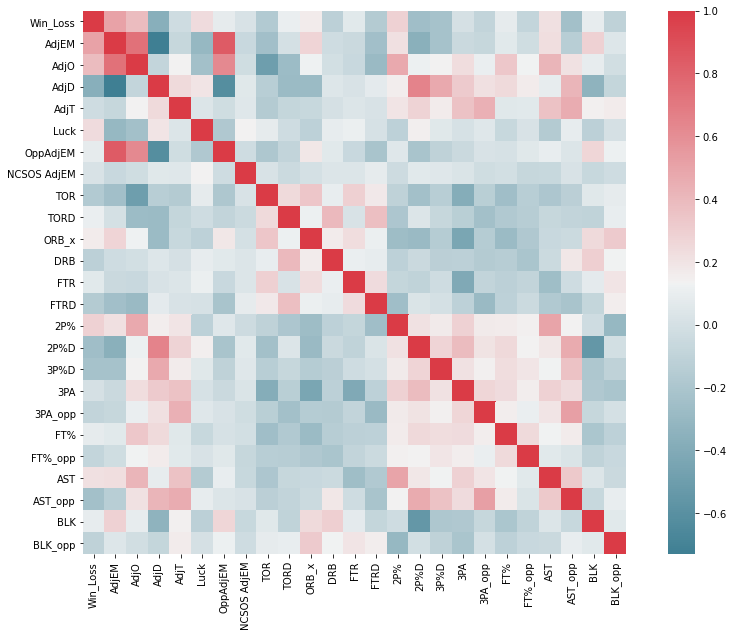

In [11]:
f, ax = plt.subplots(figsize=(15, 10))
corr = X_under_reduced.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=bool), 
            cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

In [12]:
feats_to_remove_all = feats_to_remove + ['ORB_Fav_y'] + [col + '_Fav' for col in feats_to_remove]
feats_to_remove_all.remove('ORB_y_Fav')
train_reduced = train.drop(feats_to_remove_all, axis=1, errors='ignore')
test_reduced = test.drop(feats_to_remove_all, axis=1, errors='ignore')

X_train_reduced = train_reduced.drop('Label', axis=1)
y_train_reduced = train_reduced['Label']
X_test_reduced = test_reduced.drop('Label', axis=1)
y_test_reduced = test_reduced['Label']

len(train_reduced.columns)

51

In [13]:
corr_list_reduced = X_train_reduced.corr().stack()

# Remove correlation of a feature to itself and duplicates
corr_list_reduced = corr_list_reduced[
    (corr_list_reduced.index.get_level_values(0) != corr_list_reduced.index.get_level_values(1)) &
    (corr_list_reduced.index.get_level_values(0) < corr_list_reduced.index.get_level_values(1))
]

# See top correlation by magnitude
corr_list_reduced.apply(abs).sort_values(ascending=False).head(10)

AdjEM      OppAdjEM        0.841530
AdjEM_Fav  AdjO_Fav        0.805684
AdjD_Fav   AdjEM_Fav       0.769037
AdjEM_Fav  OppAdjEM_Fav    0.751956
AdjEM      AdjO            0.742372
           AdjEM_Fav       0.732197
AdjD       AdjEM           0.730107
AdjEM_Fav  Win_Loss_Fav    0.691730
2P%D_Fav   AdjD_Fav        0.687705
2P%D       AdjD            0.652386
dtype: float64

In [14]:
# Cluster features based on correlation magnitude
corr_linkage = hierarchy.ward(X_train_reduced.corr().apply(abs))
cluster_ids = hierarchy.fcluster(corr_linkage, 1, criterion='distance')

# Show clusters with more than one feature
cluster_id_to_features = defaultdict(list)
for idx, cluster_id in enumerate(cluster_ids):
    feat = X_train_reduced.columns[idx]
    cluster_id_to_features[cluster_id].append(feat)
    
for k in cluster_id_to_features:
    if len(cluster_id_to_features[k]) > 1:
        print(cluster_id_to_features[k])

['AdjEM_Fav', 'AdjEM', 'OppAdjEM_Fav', 'OppAdjEM']
['AdjD_Fav', '2P%D_Fav']
['AdjT_Fav', '3PA_opp_Fav']
['AdjT', '3PA_opp', 'AST_opp']
['2P%_Fav', 'AST_Fav']
['2P%', 'AST']


### Test how a Model Performs with the Reduced Feature Set

From the correlation matrix, we can clearly see that the number of correlated features has been reduced dramatically. Hopefully we'll be able to create a simpler model that still has relatively the same predictive power with this reduced set of features. 

You might notice that there are still a couple of features in the data that are pretty highly correlated that I decided to keep in the set of features. Notably, I kept the `AdjEM` feature (overall team efficiency) in addition to both the defensive and offensive efficiency numbers. I felt that these features were all too important to exclude any of them, though you could definitely make an argument that the overall efficiency can easily be derived from the other two features. Another set of features that were pretty closely linked were team efficiency stats and features related to strength of schedule. Overall, better teams tend to play harder schedules so it makes sense, but I felt that these features still provided enough of a different look at the teams so I decided to keep them.

Next, we'll test out the reduced feature data with a random forest classifier to help confirm that we haven't removed too much important information that the model needed. Below, we can see that we get the same 63% accuracy on our reduced test set. While we didn't increase accuracy, I still think the reduced feature training data will help us build a more robust model for making NCAA Tournament predictions later on.

In [15]:
clf = RandomForestClassifier(n_estimators=100, random_state=77)
clf.fit(X_train_reduced, y_train_reduced)
print("Accuracy on test data: {:.2f}".format(clf.score(X_test_reduced, y_test_reduced)))

Accuracy on test data: 0.63


In [16]:
# Save all the training data to a csv - including identifier columns
training_data = pd.concat([train_reduced , test_reduced], ignore_index=False)
training_data = df[['Favored', 'Underdog', 'Year', 'Tournament']].join(training_data)
training_data.to_csv('../../Data/Training/training_feat_reduced.csv', index=False)
training_data.head()

,Favored,Underdog,Year,Tournament,Win_Loss_Fav,Win_Loss,AdjEM_Fav,AdjEM,AdjO_Fav,AdjO,...,FT%_opp_Fav,FT%_opp,AST_Fav,AST,AST_opp_Fav,AST_opp,BLK_Fav,BLK,BLK_opp_Fav,BLK_opp
0,UNC,William & Mary,2010,NIT,0.540541,0.666667,13.39,6.58,107.4,110.0,...,0.699,0.681,15.594595,14.030303,14.378378,13.151515,5.675676,2.545455,4.486486,3.333333
1,Wake Forest,UNC,2010,NaN,0.645161,0.540541,14.12,13.39,107.1,107.4,...,0.687,0.699,11.903226,15.594595,11.419355,14.378378,5.225806,5.675676,3.903226,4.486486
2,UNC,Nevada,2010,NaN,0.540541,0.617647,13.39,10.20,107.4,112.8,...,0.699,0.713,15.594595,14.117647,14.378378,15.029412,5.675676,4.382353,4.486486,2.588235
3,Syracuse,UNC,2010,NaN,0.857143,0.540541,27.62,13.39,118.5,107.4,...,0.637,0.699,19.228571,15.594595,15.514286,14.378378,6.314286,5.675676,2.285714,4.486486
4,Dayton,UNC,2010,NIT,0.675676,0.540541,18.92,13.39,108.1,107.4,...,0.657,0.699,14.702703,15.594595,11.135135,14.378378,3.459459,5.675676,3.162162,4.486486
